In [3]:
import numpy as np
import os, sys
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.insert(0, current_dir)
sys.path.insert(0, os.path.join(current_dir, 'conv_gp/'))
from conv_gp.models import ModelBuilder
from argparse import Namespace
import observations

import gpflow

In [4]:
model_path = './model.npy'
flags = Namespace(
    M='384,384,384',
    strides='3,1,1',
    feature_maps='10,10',
    filter_sizes='5,3,3',
    batch_size=64,
    base_kernel='rbf',
    last_kernel='conv',
    load_model=model_path,
    identity_mean=False,
    white=False,
    num_samples=5
)

In [5]:
(Xtrain, Ytrain), (Xtest, Ytest) = observations.cifar10('/tmp/cifar10')
Xtrain = np.transpose(Xtrain, [0, 2, 3, 1]).astype(np.float64)
Xtest = np.transpose(Xtest, [0, 2, 3, 1]).astype(np.float64)
Xtrain /= 255.0
Xtest /= 255.0

std = Xtrain.std(axis=(0, 1, 2))
mean = Xtrain.mean(axis=(0, 1, 2))
Xtrain -= mean
Xtrain /= std
Xtest -= mean
Xtest /= std

builder = ModelBuilder(flags, Xtrain, Ytrain, model_path=flags.load_model)
model = builder.build()

In [6]:
def test_accuracy_at_noise_level(noise_level):
    temp_test = (Xtest * std) + mean
    corrupted_test = temp_test + np.random.randn(*Xtest.shape) * noise_level
    corrupted_test = np.where(np.less_equal(corrupted_test, 1.0), corrupted_test, np.ones_like(corrupted_test))
    corrupted_test = np.where(np.greater_equal(corrupted_test, 0.0), corrupted_test, np.zeros_like(corrupted_test))
  
    corrupted_test -= mean
    corrupted_test /= std
    
    correct = 0
    batch_size = 64
    for i in range(len(Ytest) // batch_size + 1):
        batch_slice = slice(i * batch_size, (i+1) * batch_size)
        X = corrupted_test[batch_slice] 
        X += np.random.randn(*X.shape) * noise_level
        Y = Ytest[batch_slice]
        X = X.reshape(X.shape[0], -1) 
        mean_predict, _ = model.predict_y(X, 10)
        class_probs = mean_predict.mean(axis=0)
        predicted = class_probs.argmax(axis=1)
        correct += (predicted == Y).sum()

    accuracy = correct / len(Ytest)
    print("accuracy: {}, noise_level: {}".format(accuracy, noise_level))

In [8]:
test_accuracy_at_noise_level(0.0)
test_accuracy_at_noise_level(0.1)
test_accuracy_at_noise_level(0.25)
test_accuracy_at_noise_level(0.5)
test_accuracy_at_noise_level(1.0)

accuracy: 0.7382, noise_level: 0.0
accuracy: 0.6532, noise_level: 0.1
accuracy: 0.3371, noise_level: 0.25
accuracy: 0.154, noise_level: 0.5
accuracy: 0.1101, noise_level: 1.0


In [9]:
saved_params = np.load(model_path).item()
sess = model.enquire_session()
model_params = {}
for param in model.parameters:
    saved = saved_params[param.pathname]
    value = sess.run(param.constrained_tensor)
    model_params[param.pathname] = value
    print(param.pathname, "diff ", np.linalg.norm(saved - value))

DGP/likelihood/likelihood/invlink/epsilon diff  0.0
DGP/layers/0/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/0/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/0/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/0/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/0/feature/Z diff  0.0
DGP/layers/0/q_mu diff  0.0
DGP/layers/0/q_sqrt diff  0.0
DGP/layers/1/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/1/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/1/conv_kernel/base_kernel/variance diff  0.0
DGP/layers/1/conv_kernel/base_kernel/lengthscales diff  0.0
DGP/layers/1/feature/Z diff  0.0
DGP/layers/1/q_mu diff  0.0
DGP/layers/1/q_sqrt diff  0.0
DGP/layers/2/feature/Z diff  0.0
DGP/layers/2/kern/base_kernel/variance diff  0.0
DGP/layers/2/kern/base_kernel/lengthscales diff  0.0
DGP/layers/2/kern/patch_weights diff  0.0
DGP/layers/2/q_mu diff  0.0
DGP/layers/2/q_sqrt diff  0.0


In [40]:
Z = model.layers[0].feature.Z.value

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import umap
sns.set(style="whitegrid", palette='deep')
from kernels import _sample_patches
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('figure', figsize=(13, 8))
matplotlib.rc('axes', titlesize=22)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('axes', labelsize=16)

In [12]:
def sample_patches():
    n_patches = Z.shape[0]
    patch_size = 5
    patch_length = patch_size**2 * 3
    patches = np.zeros((n_patches, patch_length))
    for i in range(n_patches):
        random_image = Xtrain[np.random.choice(np.arange(Xtrain.shape[0]))]
        random_patch = _sample_patches(random_image, 1, patch_size, patch_length)
        patches[i, :] = random_patch
    return patches
patches = sample_patches()
Z_and_patches = np.concatenate([patches, Z])

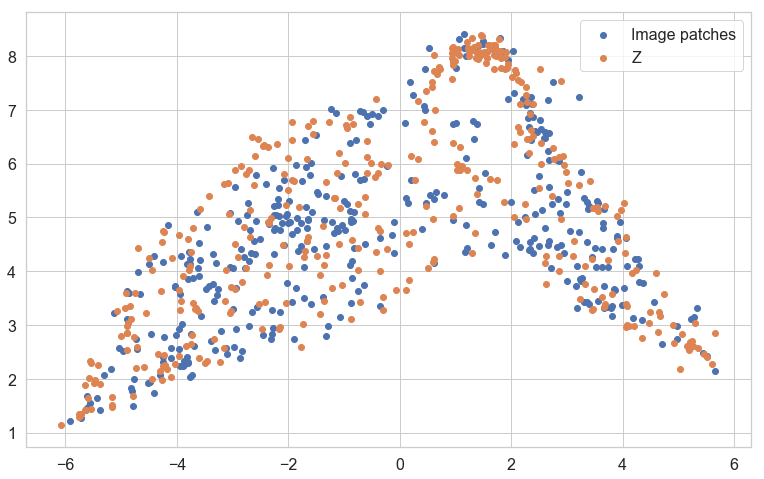

In [28]:
umap_object = umap.UMAP(n_components=2)
umap_object.fit(Z_and_patches)
embedded_Z = umap_object.transform(Z)
embedded_patches = umap_object.transform(patches)
plt.figure(figsize=(13, 8))

plt.scatter(embedded_patches[:, 0], embedded_patches[:, 1], label="Image patches")
plt.scatter(embedded_Z[:, 0], embedded_Z[:, 1], label="Z")
plt.legend();

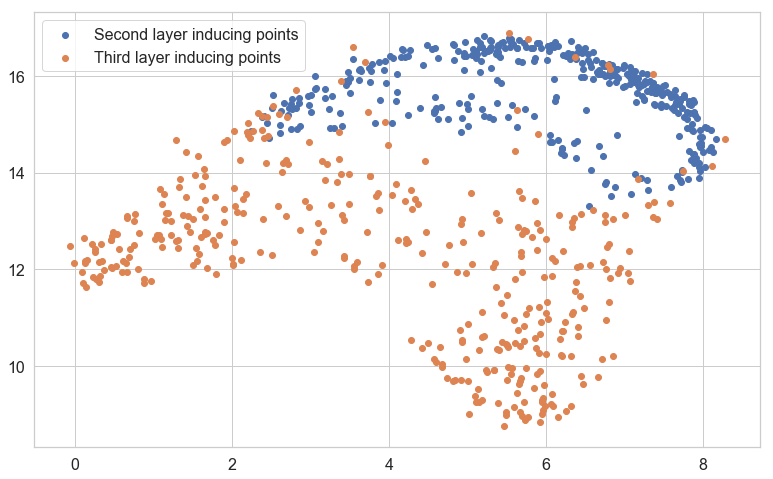

In [41]:
Z1 = model.layers[1].feature.Z.value
Z2 = model.layers[2].feature.Z.value
Z12 = np.concatenate([Z1, Z2], axis=0)

embedder = umap.UMAP(n_components=2)
embedder = embedder.fit(Z12)
Z1 = embedder.transform(Z1)
Z2 = embedder.transform(Z2)

plt.scatter(Z1[:, 0], Z1[:, 1], label="Second layer inducing points")
plt.scatter(Z2[:, 0], Z2[:, 1], label="Third layer inducing points")
plt.legend();

In [42]:
by_classes = np.stack([Xtrain[Ytrain==i][0:64] for i in range(10)])

In [43]:
layer1 = np.zeros((10, 64, 10, 10, 10))
layer2 = np.zeros((10, 64, 8, 8, 10))
layer3 = np.zeros((10, 64, 10))
sess = model.enquire_session()

for i in range(10):
    Fs, Fmeans, Fvars = model.propagate(by_classes[i, 0:64].reshape(64, -1), S=1)
    f = sess.run(Fs)
    layer1[i, :, :, :, :] = f[0].reshape(64, 10, 10, 10)
    layer2[i, :, :, :, :] = f[1].reshape(64, 8, 8, 10)
    layer3[i, :, :] = f[2].reshape(64, 10)


In [44]:
from sklearn import manifold

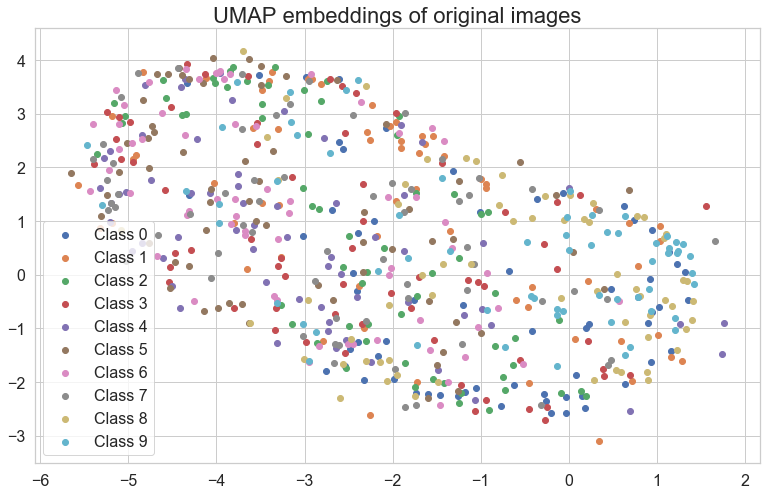

In [45]:
embedder = umap.UMAP(n_components=2)
dim = 32*32*3
embedder = embedder.fit(by_classes.reshape(640, dim))

plt.title("UMAP embeddings of original images")
for class_index in range(10):
    class_embedded = embedder.transform(by_classes[class_index].reshape(64, dim))
    plt.scatter(class_embedded[:, 0], class_embedded[:, 1], label="Class {}".format(class_index))
    
plt.legend();

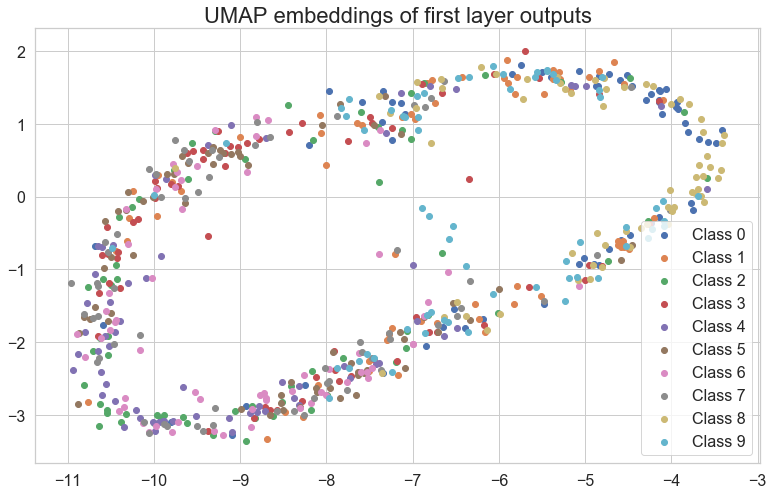

In [46]:
embedder = umap.UMAP(n_components=2)
embedded = embedder.fit(layer1.reshape(64 * 10, 1000))

plt.title('UMAP embeddings of first layer outputs')
for i in range(10):
    class_embedded = embedder.transform(layer1[i].reshape(64, 1000))
    plt.scatter(class_embedded[:, 0], class_embedded[:, 1], label="Class {}".format(i))

plt.legend();

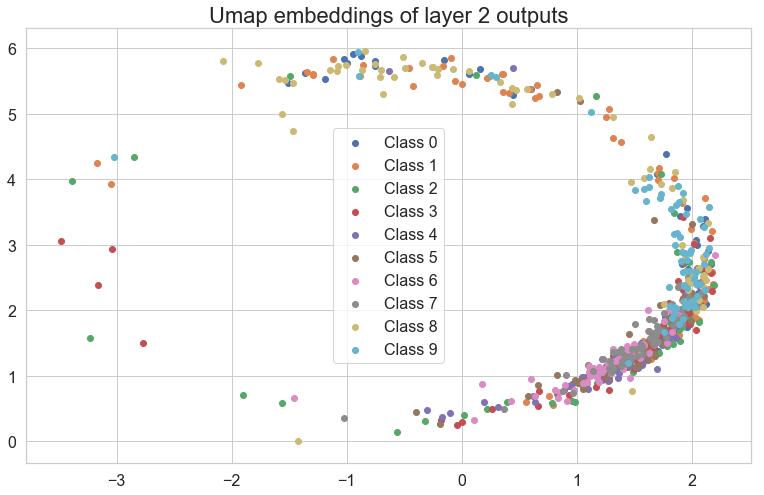

In [47]:
embedder = umap.UMAP(n_components=2)
dim = 8*8*10
embedded = embedder.fit(layer2.reshape(64*10, dim))

plt.title("Umap embeddings of layer 2 outputs")
for i in range(10):
    class_embedded = embedder.transform(layer2[i].reshape(64, dim))
    plt.scatter(class_embedded[:, 0], class_embedded[:, 1], label="Class {}".format(i))

plt.legend();

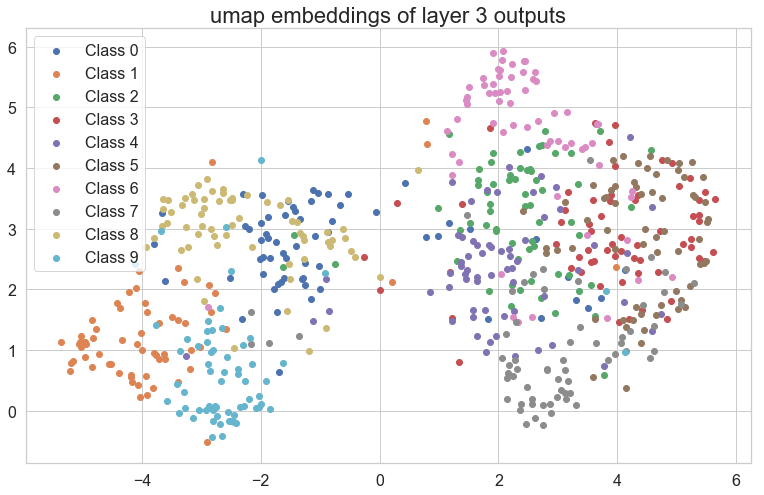

In [48]:
embedder = umap.UMAP(n_components=2)
dim = 10
embedded = embedder.fit(layer3.reshape(64*10, dim))

plt.title("umap embeddings of layer 3 outputs")
for i in range(10):
    class_embedded = embedder.transform(layer3[i].reshape(64, dim))
    plt.scatter(class_embedded[:, 0], class_embedded[:, 1], label="Class {}".format(i))

plt.legend();

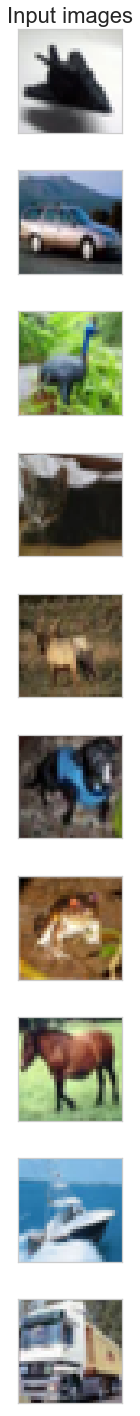

In [49]:
figure = plt.figure(figsize=(2, 20))
for class_index in range(10):
    axis = plt.subplot2grid((10, 1), loc=(class_index, 0))
    if class_index == 0:
        axis.set_title("Input images")
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    image = by_classes[class_index, 0, :, :, :] * std + mean
    axis.imshow(image)
        
plt.tight_layout();

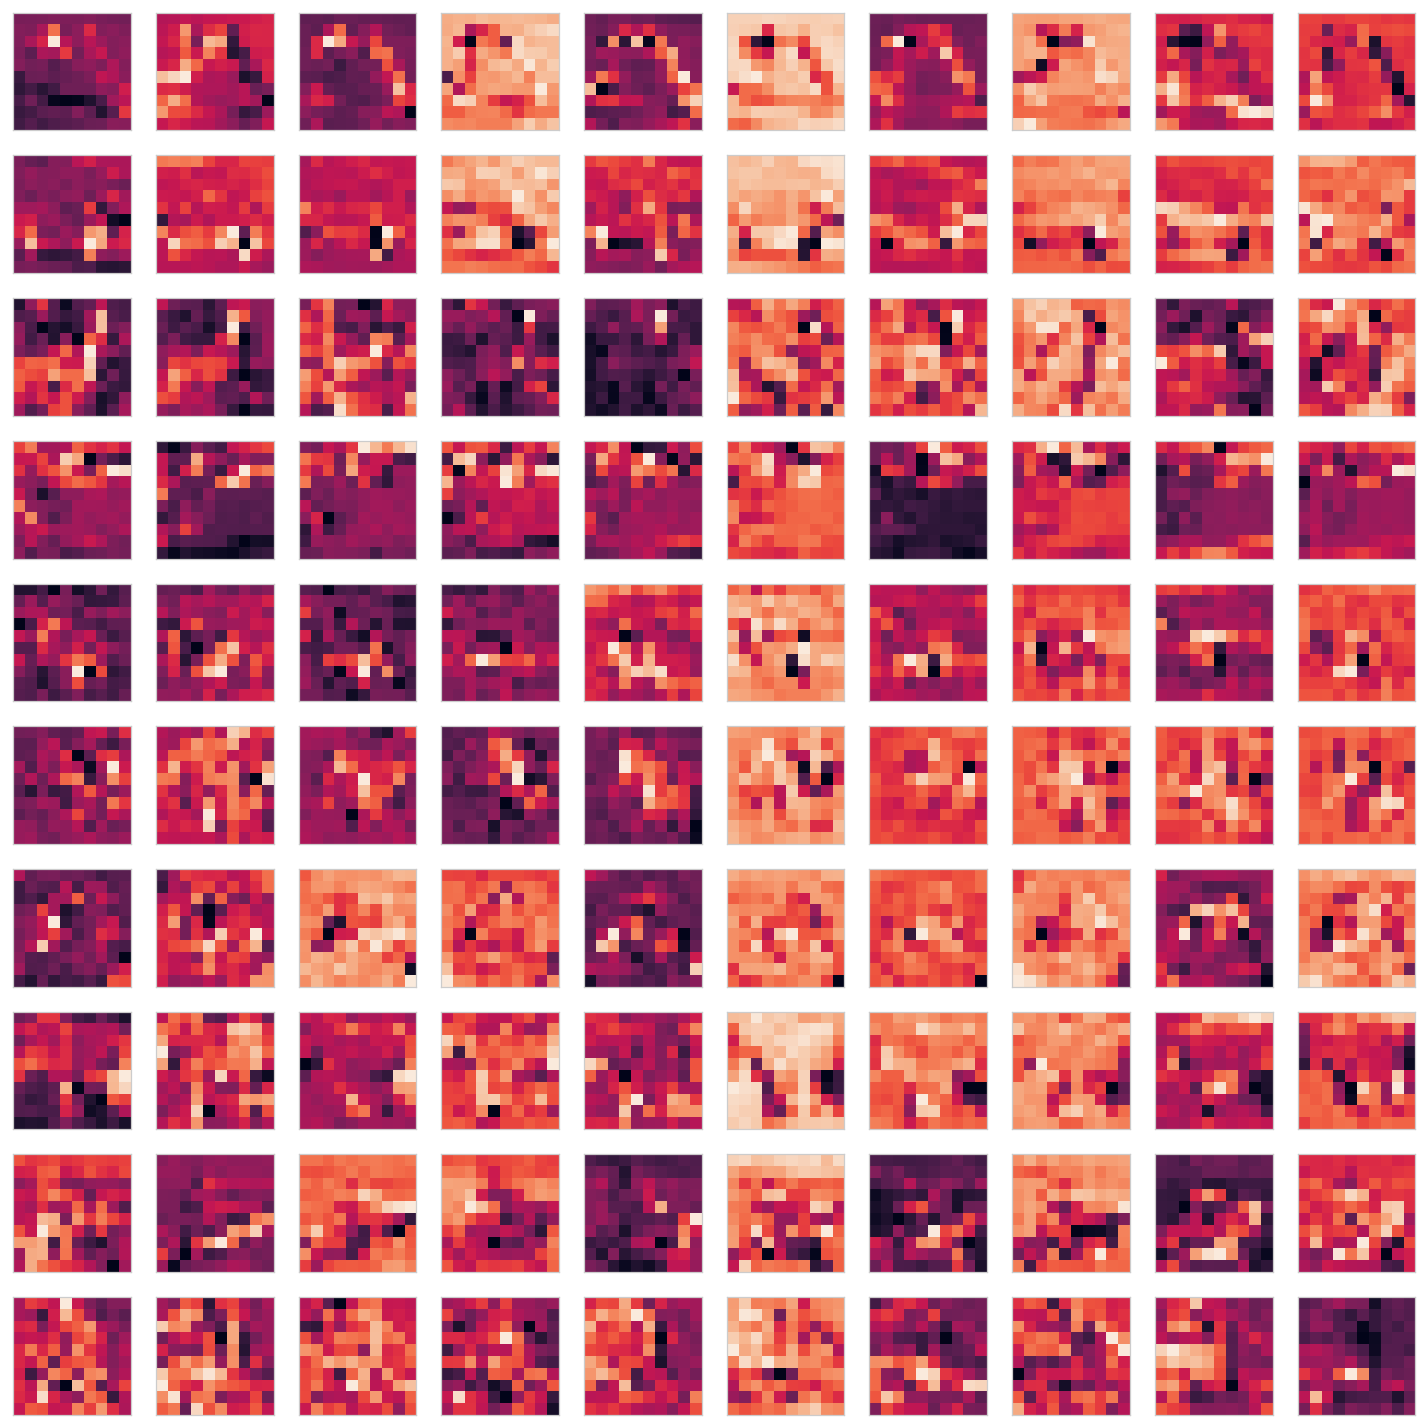

In [50]:
n_feature_maps = 10
figure = plt.figure(figsize=(n_feature_maps * 2, 20))
for class_index in range(10):
    for feature_map in range(n_feature_maps):
        axis = plt.subplot2grid((10, n_feature_maps), loc=(class_index, feature_map))
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        image = layer1[class_index, 0, :, :, feature_map]
        axis.imshow(image)
        
plt.tight_layout();
# The "x-axis" of the grid represents different feature maps and the "y-axis" are activations over different classes.

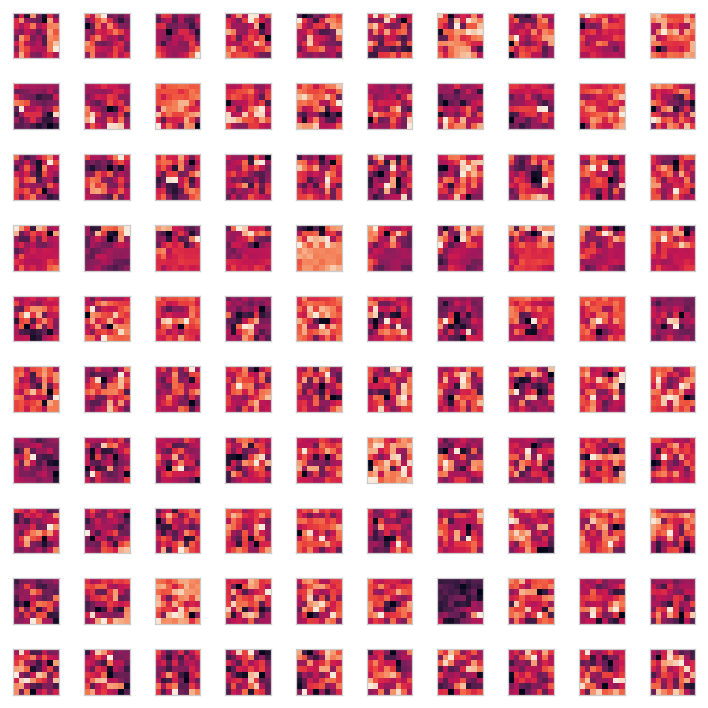

In [51]:
n_feature_maps = 10
figure = plt.figure(figsize=(n_feature_maps * 1, 10))
for class_index in range(10):
    for feature_map in range(n_feature_maps):
        axis = plt.subplot2grid((10, n_feature_maps), loc=(class_index, feature_map))
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        image = layer2[class_index, 0, :, :, feature_map]
        axis.imshow(image)
        
plt.tight_layout();
# The "x-axis" of the grid represents different feature maps and the "y-axis" are activations over different classes.

In [111]:
from sklearn import calibration
probabilities = np.zeros((Xtest.shape[0], 10), dtype=np.float64)

batch_size = 32
for batch_index in range(Xtest.shape[0] // 32 + 1):
    the_slice = slice(batch_index * batch_size, (batch_index+1) * batch_size)
    X = Xtest[the_slice]
    mean, _ = model.predict_y(X.reshape(X.shape[0], -1), 1)
    y = Ytest[the_slice]
    probabilities[the_slice, :] = mean[0]


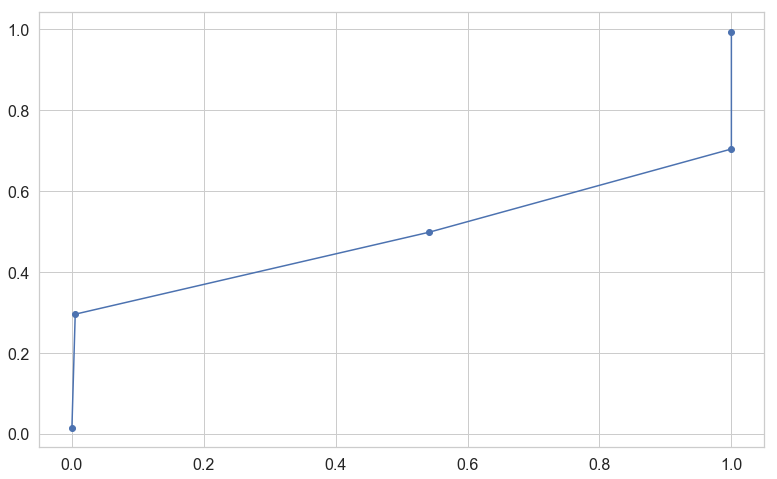

In [154]:
confidence = np.zeros((probabilities.shape[0],))
Y = np.zeros((Ytest.shape[0],), dtype=np.int32)
for i in range(probabilities.shape[0]):
    correct_class_confidence = probabilities[i, Ytest[i]]
    confidence[i] = correct_class_confidence
    Y[i] = Ytest[i] == probabilities[i].argmax()

curve = calibration.calibration_curve(Y, confidence)

plt.plot(curve[0], curve[1], marker='o');

In [145]:
Y = np.zeros((Ytest.shape[0], 10))
for i in range(Ytest.shape[0]):
    Y[i, Ytest[i]] = 1.0

brier_score = np.power(Y - probabilities, 2).mean()
print("Brier score:", brier_score)

Brier score: 0.04872524639426405


In [146]:
(Y - probabilities)[0]

array([-0.00011111, -0.00011111, -0.00011111,  0.00189911, -0.00011111,
       -0.00021139, -0.00011111, -0.00011111, -0.00011112, -0.00011111])